In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
import time
import pickle
from termcolor import colored

In [2]:
def genData(file,max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,
             'L':11,'K':12,'M':13,'F':14,'P':15,'O':16,'S':17,'U':18,'T':19,
             'W':20,'Y':21,'V':22,'X':23}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
        
    long_pep_counter=0
    pep_codes=[]
    labels=[]
    for pep in lines:
        pep,label=pep.split(",")
        labels.append(int(label))
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(torch.tensor(current_pep))
        else:
            long_pep_counter += 1
    print("length > {}:".format(max_len),long_pep_counter)
    data = rnn_utils.pad_sequence(pep_codes, batch_first=True)  # padding
    return data,torch.tensor(labels)

In [3]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        acc_sum += (outputs.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

def to_log(log):
    with open("../compareModel/2021ACS_PepFormer/modelLog.log","a+") as f:
        f.write(log+'\n')

In [4]:
def collate(batch):
    seq1_ls=[]
    seq2_ls=[]
    label1_ls=[]
    label2_ls=[]
    label_ls=[]
    batch_size=len(batch)
    for i in range(int(batch_size/2)):
        seq1,label1=batch[i][0],batch[i][1]
        seq2,label2=batch[i+int(batch_size/2)][0],batch[i+int(batch_size/2)][1]
        label1_ls.append(label1.unsqueeze(0))
        label2_ls.append(label2.unsqueeze(0))
        label=(label1^label2)
        seq1_ls.append(seq1.unsqueeze(0))
        seq2_ls.append(seq2.unsqueeze(0))
        label_ls.append(label.unsqueeze(0))
    seq1=torch.cat(seq1_ls).to(device)
    seq2=torch.cat(seq2_ls).to(device)
    label=torch.cat(label_ls).to(device)
    label1=torch.cat(label1_ls).to(device)
    label2=torch.cat(label2_ls).to(device)
    return seq1,seq2,label,label1,label2
    

# New Train

# 1. Make Data X_train, y_train, X_test, y_test

In [7]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm_210930_includeDigest.csv')
df_detect_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm_210930_includeDigest.csv')

tra, val = train_test_split(df_detect_peptide_train[['PEP', 'ID']], test_size=0.2, random_state=7)
tra.to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_train_noptm_includeDigest.csv', header=False, index=False)
val.to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_val_noptm_includeDigest.csv', header=False, index=False)
df_detect_peptide_test[['PEP', 'ID']].to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_test_noptm_includeDigest.csv', header=False, index=False)

In [9]:
train_data,train_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_train_noptm_includeDigest.csv",81)
print(train_data.shape, train_label.shape)
train_dataset = Data.TensorDataset(train_data, train_label)

val_data,val_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_val_noptm_includeDigest.csv",81)
print(val_data.shape, val_label.shape)
val_dataset = Data.TensorDataset(val_data, val_label)

test_data,test_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_test_noptm_includeDigest.csv",81)
print(test_data.shape, test_label.shape)
test_dataset = Data.TensorDataset(test_data, test_label)

batch_size=256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iter_cont = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                                                  shuffle=True, collate_fn=collate)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

length > 81: 0
torch.Size([337179, 30]) torch.Size([337179])
length > 81: 0
torch.Size([84295, 30]) torch.Size([84295])
length > 81: 0
torch.Size([88998, 30]) torch.Size([88998])


# 2. train

In [10]:
class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(1600,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance: [128]
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calmp夹断用法
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))     
        
        return loss_contrastive
    
    


In [11]:
device = torch.device("cuda",0)

In [12]:
for num_model in range(1):  # just one train
    net=newModel().to(device)
    lr = 0.0001
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=5e-4)
    criterion = ContrastiveLoss()
    criterion_model = nn.CrossEntropyLoss(reduction='sum')
    
    best_acc=0
    EPOCH=250
    for epoch in range(EPOCH):
        loss_ls=[]
        loss1_ls=[]
        loss2_3_ls=[]
        t0=time.time()
        net.train()
        for seq1,seq2,label,label1,label2 in train_iter_cont:
                output1=net(seq1)
                output2=net(seq2)
                output3=net.trainModel(seq1)
                output4=net.trainModel(seq2)
                
                loss1=criterion(output1, output2, label)
                loss2=criterion_model(output3,label1)
                loss3=criterion_model(output4,label2)
                loss=loss1+loss2+loss3
    #             print(loss)
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                loss_ls.append(loss.item())
                loss1_ls.append(loss1.item())
                loss2_3_ls.append((loss2+loss3).item())


        net.eval() 
        with torch.no_grad(): 
            train_acc=evaluate_accuracy(train_iter,net)
            test_acc=evaluate_accuracy(val_iter,net)
            
        results=f"epoch: {epoch+1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
        results+=f'\ttrain_acc: {train_acc:.4f}, test_acc: {colored(test_acc,"red")}, time: {time.time()-t0:.2f}'
        print(results)
        if test_acc>best_acc:
            best_acc=test_acc
#             torch.save({"best_acc":best_acc,"model":net.state_dict()},f'compareModel/2021ACS_PepFormer/Model/{num_model}.pl')
            print(f"best_acc: {best_acc}")

epoch: 1, loss: 139.59932, loss1: 1.30797, loss2_3: 138.29135
	train_acc: 0.7901, test_acc: 0.7879826798742512, time: 276.00
best_acc: 0.7879826798742512
epoch: 2, loss: 106.43848, loss1: 0.86041, loss2_3: 105.57807
	train_acc: 0.8031, test_acc: 0.8038910967435791, time: 293.25
best_acc: 0.8038910967435791
epoch: 3, loss: 100.72217, loss1: 0.81356, loss2_3: 99.90861
	train_acc: 0.8303, test_acc: 0.82855448128596, time: 293.20
best_acc: 0.82855448128596
epoch: 4, loss: 97.44314, loss1: 0.78819, loss2_3: 96.65495
	train_acc: 0.8354, test_acc: 0.8329794175217985, time: 292.15
best_acc: 0.8329794175217985
epoch: 5, loss: 96.03921, loss1: 0.77320, loss2_3: 95.26601
	train_acc: 0.8340, test_acc: 0.8321964529331515, time: 292.70
epoch: 6, loss: 94.32667, loss1: 0.75987, loss2_3: 93.56680
	train_acc: 0.8336, test_acc: 0.8307372916543093, time: 294.04
epoch: 7, loss: 93.50809, loss1: 0.75036, loss2_3: 92.75773
	train_acc: 0.8402, test_acc: 0.8384483065424996, time: 292.62
best_acc: 0.8384483065

epoch: 59, loss: 82.83264, loss1: 0.65754, loss2_3: 82.17510
	train_acc: 0.8556, test_acc: 0.8509638768610238, time: 177.08
epoch: 60, loss: 82.75300, loss1: 0.65638, loss2_3: 82.09662
	train_acc: 0.8586, test_acc: 0.8548312474049469, time: 176.53
epoch: 61, loss: 82.74594, loss1: 0.65736, loss2_3: 82.08858
	train_acc: 0.8596, test_acc: 0.8548075212052909, time: 175.41
epoch: 62, loss: 82.73167, loss1: 0.65721, loss2_3: 82.07446
	train_acc: 0.8616, test_acc: 0.8572038673705439, time: 175.06
best_acc: 0.8572038673705439
epoch: 63, loss: 82.65339, loss1: 0.65544, loss2_3: 81.99794
	train_acc: 0.8608, test_acc: 0.854724479506495, time: 175.02
epoch: 64, loss: 82.53259, loss1: 0.65437, loss2_3: 81.87823
	train_acc: 0.8606, test_acc: 0.856290408683789, time: 175.40
epoch: 65, loss: 82.53944, loss1: 0.65527, loss2_3: 81.88417
	train_acc: 0.8613, test_acc: 0.8563971765822409, time: 176.60
epoch: 66, loss: 82.50135, loss1: 0.65294, loss2_3: 81.84840
	train_acc: 0.8602, test_acc: 0.855756569191

epoch: 120, loss: 80.77429, loss1: 0.64381, loss2_3: 80.13048
	train_acc: 0.8657, test_acc: 0.8589714692449137, time: 358.13
best_acc: 0.8589714692449137
epoch: 121, loss: 80.73055, loss1: 0.64456, loss2_3: 80.08599
	train_acc: 0.8641, test_acc: 0.8569903315736402, time: 358.16
epoch: 122, loss: 80.74287, loss1: 0.64237, loss2_3: 80.10050
	train_acc: 0.8656, test_acc: 0.8590307847440536, time: 359.10
best_acc: 0.8590307847440536
epoch: 123, loss: 80.65782, loss1: 0.64276, loss2_3: 80.01506
	train_acc: 0.8663, test_acc: 0.8582596832552346, time: 358.15
epoch: 124, loss: 80.63107, loss1: 0.64195, loss2_3: 79.98911
	train_acc: 0.8655, test_acc: 0.8583545880538584, time: 358.34
epoch: 125, loss: 80.64049, loss1: 0.64331, loss2_3: 79.99718
	train_acc: 0.8646, test_acc: 0.8562785455839611, time: 358.25
epoch: 126, loss: 80.76110, loss1: 0.64376, loss2_3: 80.11735
	train_acc: 0.8655, test_acc: 0.8577377068628033, time: 357.99
epoch: 127, loss: 80.64473, loss1: 0.64387, loss2_3: 80.00086
	trai

epoch: 181, loss: 79.43108, loss1: 0.63476, loss2_3: 78.79632
	train_acc: 0.8688, test_acc: 0.8592680467406133, time: 299.28
epoch: 182, loss: 79.58684, loss1: 0.63800, loss2_3: 78.94884
	train_acc: 0.8682, test_acc: 0.8583071356545465, time: 299.67
epoch: 183, loss: 79.53632, loss1: 0.63639, loss2_3: 78.89993
	train_acc: 0.8647, test_acc: 0.8557209798920458, time: 300.49
epoch: 184, loss: 79.48507, loss1: 0.63674, loss2_3: 78.84833
	train_acc: 0.8626, test_acc: 0.8540720090159559, time: 300.36
epoch: 185, loss: 79.46783, loss1: 0.63749, loss2_3: 78.83034
	train_acc: 0.8687, test_acc: 0.8591375526425055, time: 299.89
epoch: 186, loss: 79.46192, loss1: 0.63530, loss2_3: 78.82662
	train_acc: 0.8638, test_acc: 0.853953378017676, time: 303.40
epoch: 187, loss: 79.46401, loss1: 0.63447, loss2_3: 78.82954
	train_acc: 0.8665, test_acc: 0.8572157304703719, time: 299.79
epoch: 188, loss: 79.48343, loss1: 0.63451, loss2_3: 78.84892
	train_acc: 0.8699, test_acc: 0.8588409751468059, time: 300.51
e

epoch: 242, loss: 78.52725, loss1: 0.63062, loss2_3: 77.89664
	train_acc: 0.8721, test_acc: 0.8591494157423335, time: 244.41
epoch: 243, loss: 78.55216, loss1: 0.62896, loss2_3: 77.92320
	train_acc: 0.8687, test_acc: 0.8568005219763924, time: 243.13
epoch: 244, loss: 78.50539, loss1: 0.62977, loss2_3: 77.87562
	train_acc: 0.8702, test_acc: 0.8576783913636633, time: 244.97
epoch: 245, loss: 78.39053, loss1: 0.62802, loss2_3: 77.76251
	train_acc: 0.8717, test_acc: 0.8592443205409573, time: 245.80
epoch: 246, loss: 78.51140, loss1: 0.62901, loss2_3: 77.88239
	train_acc: 0.8704, test_acc: 0.8585088083516222, time: 245.60
epoch: 247, loss: 78.49866, loss1: 0.63033, loss2_3: 77.86833
	train_acc: 0.8661, test_acc: 0.8549024260039149, time: 245.08
epoch: 248, loss: 78.45573, loss1: 0.63126, loss2_3: 77.82447
	train_acc: 0.8702, test_acc: 0.8576665282638354, time: 244.37
epoch: 249, loss: 78.36103, loss1: 0.63056, loss2_3: 77.73047
	train_acc: 0.8722, test_acc: 0.8594934456373451, time: 244.58


# 3. test

In [13]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [14]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

In [15]:
def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

In [16]:
test_acc = evaluate_accuracy(test_iter,net)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = pred(test_iter, net)
print(classification_report(test_label, y_pred))

Test Accuracy: 0.8671543180745634
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     44509
           1       0.83      0.92      0.87     44489

    accuracy                           0.87     88998
   macro avg       0.87      0.87      0.87     88998
weighted avg       0.87      0.87      0.87     88998



rf auc : 0.9412683037821481


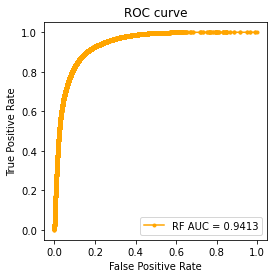

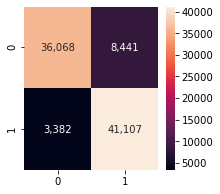

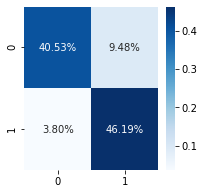

In [17]:
# AUC
probs = np.array(pred_prob(test_iter, net))[:, 1]
rf_auc = roc_auc_score(test_label, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model81
rf_fpr, rf_tpr, _ = roc_curve(test_label, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()